<a href="https://colab.research.google.com/github/Mohammed-Taher6705/jigsaw-puzzle-matching/blob/main/Image_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/Mohammed-Taher6705/jigsaw-puzzle-matching.git


Cloning into 'jigsaw-puzzle-matching'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (465/465), done.
remote: Total 467 (delta 7), reused 446 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (467/467), 24.97 MiB | 33.78 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cell 1: find the zip under /content/jigsaw-puzzle-matching and unzip
import os
from pprint import pprint
base_folder = "/content/jigsaw-puzzle-matching"
zip_candidates = [f for f in os.listdir(base_folder) if f.lower().endswith(".zip")]
print("Zip files found in", base_folder, ":\n", zip_candidates)

if not zip_candidates:
    raise FileNotFoundError("No .zip found in /content/jigsaw-puzzle-matching. Make sure 'Images dataset files.zip' is there.")

# choose the one you added (if multiple, picks first)
zip_name = zip_candidates[0]
zip_path = os.path.join(base_folder, zip_name)
print("Using zip:", zip_path)

extract_to = os.path.join(base_folder, "dataset")

# unzip quietly (handles spaces)
!unzip -q "{zip_path}" -d "{extract_to}"
print("Unzipped to:", extract_to)

print("\nTop-level entries under the extraction folder:")
pprint(sorted(os.listdir(extract_to)))


In [5]:
# Cell 2: detect dataset root that contains expected folders
import os
expected = {"correct", "puzzle_2x2", "puzzle_4x4", "puzzle_8x8"}

def has_expected(root):
    if not os.path.isdir(root):
        return False
    entries = set([name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))])
    return expected.issubset(entries)

EXTRACT_TO = os.path.join("/content","jigsaw-puzzle-matching","dataset")
candidates = [EXTRACT_TO] + [os.path.join(EXTRACT_TO, x) for x in os.listdir(EXTRACT_TO)]

BASE_PATH = None
for c in candidates:
    if has_expected(c):
        BASE_PATH = c
        break

if BASE_PATH is None:
    print("Could not find all expected folders (correct, puzzle_2x2, puzzle_4x4, puzzle_8x8).")
    print("Contents of extraction folder:")
    print(sorted(os.listdir(EXTRACT_TO)))
    raise FileNotFoundError("Please inspect the printed contents and ensure the zip contains the expected folders.")
else:
    print("Detected dataset BASE_PATH:", BASE_PATH)
    print("Contents:")
    print(sorted(os.listdir(BASE_PATH)))


Detected dataset BASE_PATH: /content/jigsaw-puzzle-matching/dataset
Contents:
['correct', 'puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']


In [20]:
## CELL 3 — Load images from each folder (JPG only)

import cv2
import os
from glob import glob

paths = {
    "correct":      os.path.join(BASE_PATH, "correct"),
    "puzzle_2x2":   os.path.join(BASE_PATH, "puzzle_2x2"),
    "puzzle_4x4":   os.path.join(BASE_PATH, "puzzle_4x4"),
    "puzzle_8x8":   os.path.join(BASE_PATH, "puzzle_8x8"),
}

def load_images_from_folder(folder_path):
    image_paths = sorted(glob(os.path.join(folder_path, "*.jpg")))
    images = []
    for p in image_paths:
        img = cv2.imread(p)
        if img is not None:
            images.append((os.path.basename(p), img, p))
    return images

datasets = {}
for name, path in paths.items():
    if os.path.isdir(path):
        datasets[name] = load_images_from_folder(path)
    else:
        datasets[name] = []
    print(f"{name}: {len(datasets[name])} images loaded.")


correct: 0 images loaded.
puzzle_2x2: 110 images loaded.
puzzle_4x4: 110 images loaded.
puzzle_8x8: 110 images loaded.



Processing: puzzle_2x2
 sample: 0.jpg


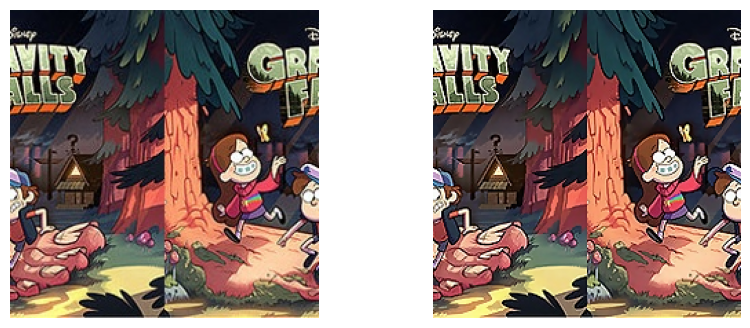

In [ ]:
#task1: bilateral then sharpen filters
import os, shutil, cv2, numpy as np
from glob import glob
import matplotlib.pyplot as plt

DATASET_ROOT="/content/jigsaw-puzzle-matching/dataset"
OUTPUT_ROOT="/content/dataset_filtered"
PUZZLE=["puzzle_2x2","puzzle_4x4","puzzle_8x8"]

def pad_gray(img, p):
    return np.pad(img, ((p,p),(p,p)), mode='reflect')

def apply_gray_filter(img, k):
    s=k.shape[0]; p=s//2
    pad=pad_gray(img,p)
    out=np.zeros_like(img,dtype=np.float32)
    ksum=k.sum() if k.sum()!=0 else 1.0
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            out[r,c]=np.sum(pad[r:r+s, c:c+s]*k)/ksum
    return np.clip(out,0,255).astype(np.uint8)

def apply_color_filter(img,k):
    b,g,r=cv2.split(img)
    return cv2.merge([
        apply_gray_filter(b,k),
        apply_gray_filter(g,k),
        apply_gray_filter(r,k)
    ])

sharpen_kernel = np.array([[0,-0.3,0],
                           [-0.3,3,-0.3],
                           [0,-0.3,0]], dtype=np.float32)

if os.path.exists(OUTPUT_ROOT):
    shutil.rmtree(OUTPUT_ROOT)
os.makedirs(OUTPUT_ROOT)

for split in PUZZLE:
    print("\nProcessing:", split)

    src=os.path.join(DATASET_ROOT,split)
    dst=os.path.join(OUTPUT_ROOT,split)
    os.makedirs(dst, exist_ok=True)

    files = sorted(glob(os.path.join(src,"*.*")))
    printed = False

    for p in files:
        img = cv2.imread(p)
        if img is None:
            continue

        smooth = cv2.bilateralFilter(img, d=5, sigmaColor=30, sigmaSpace=30)
        final = apply_color_filter(smooth,sharpen_kernel)

        outp = os.path.join(dst, os.path.basename(p))
        cv2.imwrite(outp, final)

        if not printed:
            print(" sample:", os.path.basename(p))

            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis("off")
            plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB)); plt.axis("off")

            figpath = os.path.join(dst, os.path.splitext(os.path.basename(p))[0] + "_before_after.png")
            plt.savefig(figpath, dpi=200, bbox_inches='tight')
            plt.show()

            printed = True
